# effectiveness re-evaluation from the survey

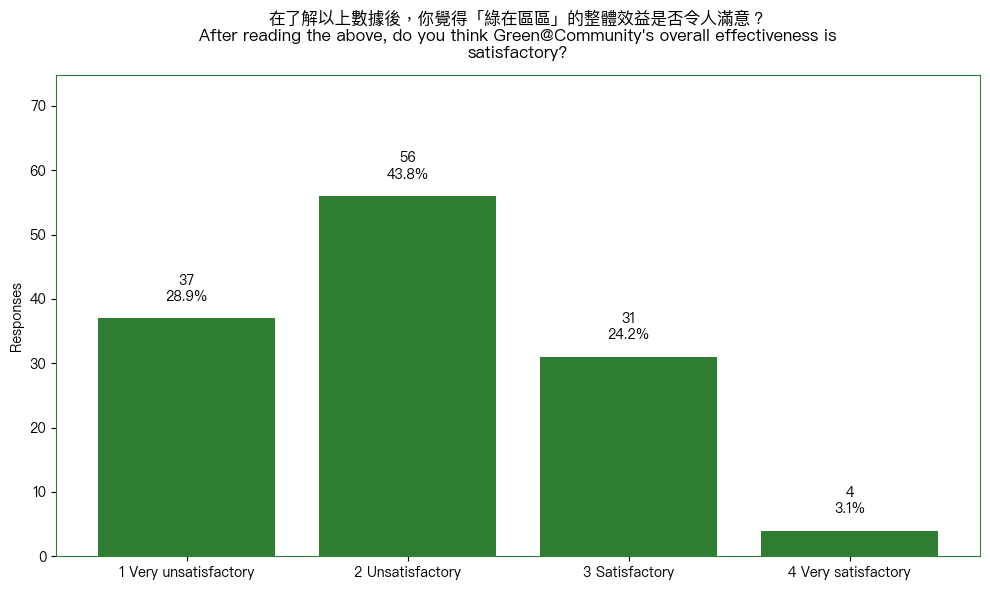

In [1]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
_ensure("pandas"); _ensure("openpyxl"); _ensure("matplotlib")

# ---------- imports ----------
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- find the column for this question (CN/EN; robust to spacing) ----------
patterns = [
    r"do\s+you\s+think\s+green@community'?s?\s+overall\s+effectiveness\s+is\s+satisfactory",
    r"整體效益.*是否.*滿意|是否令人滿意",
]
def find_col(columns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    # fallback heuristic
    for c, norm in cols:
        if re.search(r"green@community", norm, flags=re.IGNORECASE) and \
           re.search(r"satisfactor|滿意|效益", norm, flags=re.IGNORECASE):
            return c
    return None

col = find_col(df.columns)
if col is None:
    raise RuntimeError("Could not find the survey column for the 'overall effectiveness satisfactory' question.")

series = df[col].dropna()

# ---------- map responses to Likert 1–4 ----------
text_to_num = {
    "very unsatisfactory": 1, "非常不滿意": 1, "極不滿意": 1, "1": 1, 1: 1,
    "unsatisfactory": 2, "不滿意": 2, "較不滿意": 2, "2": 2, 2: 2,
    "satisfactory": 3, "滿意": 3, "較滿意": 3, "3": 3, 3: 3,
    "very satisfactory": 4, "非常滿意": 4, "極滿意": 4, "4": 4, 4: 4,
}
def to_num(v):
    s = str(v).strip().lower()
    return text_to_num.get(v, text_to_num.get(s))

nums = series.map(to_num).dropna().astype(int)

label_map = {
    1: "1 Very unsatisfactory",
    2: "2 Unsatisfactory",
    3: "3 Satisfactory",
    4: "4 Very satisfactory",
}
order  = [1, 2, 3, 4]
labels = [label_map[i] for i in order]
counts = nums.value_counts().reindex(order, fill_value=0)
total  = int(counts.sum())
pct    = (counts / total * 100).round(1) if total > 0 else counts.astype(float)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK", "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- plot (vertical bars; GREEN; counts + %) ----------
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.set_facecolor("white")

bar_color = "#2e7d32"      # green bars
border_color = "#2e7d32"   # green border
for spine in ax.spines.values():
    spine.set_color(border_color)
ax.tick_params(colors="black")
ax.grid(False)

bars = ax.bar(labels, counts.values, color=bar_color)

# give headroom for labels
ymax = max(1, counts.max())
ax.set_ylim(0, ymax * 1.30 + 2)

# value labels (count + percent) above each bar
for rect, v, p in zip(bars, counts.values, pct.values):
    ax.text(
        rect.get_x() + rect.get_width()/2,
        rect.get_height() + ymax * 0.04,
        f"{int(v)}\n{p:.1f}%",
        ha="center", va="bottom", fontsize=10
    )

ax.set_ylabel("Responses")
title_cn = "在了解以上數據後，你覺得「綠在區區」的整體效益是否令人滿意？"
title_en = "After reading the above, do you think Green@Community's overall effectiveness is satisfactory?"
ax.set_title(title_cn + "\n" + "\n".join(wrap(title_en, 80)), pad=12)

plt.tight_layout()
plt.show()
